# Image Classifier

### Dataset -> Fashion-MNIST, IMAGENET, CIFAR10

- Import Dataset
- Design model
- Specify Hyperparameters
- Forward Prop
- Compute Loss
- Backward Prop
- Update Gradients

In [216]:
!pip install torch
!pip install torchvision
!pip install livelossplot

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
from livelossplot import PlotLosses
import matplotlib.pyplot
% matplotlib inline

In [228]:
torch.cuda.is_available()

True

#### Model

In [0]:
class Net(nn.Module):
    def __init__(self,input_channel,hidden_channel,out_channel, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.conv2d = nn.Conv2d(input_channel,hidden_channel,
                                kernel_size=3,
                                stride=1,padding=1)
        self.conv2d_p = nn.Conv2d(hidden_channel, out_channel,
                                 kernel_size= 5, stride=1)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
        self.BatchNorm2d = nn.BatchNorm2d(hidden_channel)  # n_Channel
        self.BatchNorm2d_p = nn.BatchNorm2d(out_channel)
        self.sigmoid = nn.Sigmoid()
        self.MaxPool2d = nn.MaxPool2d(kernel_size=3,stride=1)
        self.Dropout2d = nn.Dropout2d(p=0.5)
        
    def forward(self, x):
        x = self.conv2d(x)
        x = self.BatchNorm2d(x)
        x = self.MaxPool2d(x)
        x = self.relu(x)
        x = self.conv2d_p(x)
        x = self.BatchNorm2d_p(x)
        x = F.relu(F.max_pool2d(x,3))
        x = x.reshape(x.size(0),-1) 
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.Dropout2d(x)
        x = self.fc2(x)
        return x
        

### Dataset load

In [219]:
train_data = torchvision.datasets.CIFAR10(root = './data',
                                              train = True,
                                              transform = transforms.ToTensor(),
                                              download = True)

test_data = torchvision.datasets.CIFAR10(root = './data',
                                             train = False,
                                             transform = transforms.ToTensor(),
                                             download = True)

train_loader = torch.utils.data.DataLoader(dataset= train_data,
                                          batch_size= 100,
                                          shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset= test_data,
                                         batch_size = 100,
                                         shuffle = False)

Files already downloaded and verified
Files already downloaded and verified


Implementation

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
input_channel = 3
hidden_channel = 15
out_channel = 25
num_classes = 10
input_size = out_channel*8*8
hidden_size = 500
epochs = 25
total_step = len(train_loader)

In [0]:
model = Net(input_channel,hidden_channel,out_channel, input_size, hidden_size, num_classes).to(device)

In [0]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [0]:
liveloss = PlotLosses()

In [225]:
for epoch in range(epochs):
    avg_accuracy = 0
    avg_loss = 0
    total = 0
    val_total = 0
    val_avg_loss = 0
    val_avg_accuracy = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1,input_channel,32,32).to(device)
        labels = labels.to(device)
        
        #Forward Prop
        output = model(images)
        loss = criterion(output, labels)
        
        _,predicted = torch.max(output.data, 1)

        total += labels.size(0)
        avg_loss += loss.item()
        avg_accuracy += (labels == predicted).sum().item()
        
        #Backward Prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1)%(total_step) == 0:
            print('Epoch: {}/{}, step: {}/{}, loss: {:.4f}'.format(epoch+1,
                                                              epochs,
                                                              i+1,
                                                              total_step,
                                                              loss.item()))
        
      
        
        
  # The below code is for only validation loss and accuracy 
    
    for val_images, val_labels in test_loader:
      val_images = val_images.reshape(-1, input_channel,32,32).to(device)
      val_labels = val_labels.to(device)
      
      val_output = model(val_images)
      val_loss = criterion(val_output, val_labels)
      _, val_predicted = torch.max(val_output.data, 1)
      
      val_total += val_labels.size(0)
      val_avg_loss += val_loss.item()
      val_avg_accuracy += (val_labels == val_predicted).sum().item()
    
    avg_loss = avg_loss/total_step
    avg_accuracy = avg_accuracy/total
    val_avg_loss = val_avg_loss/ total_step
    val_avg_accuracy = val_avg_accuracy/ val_total
    liveloss.update({'log loss': avg_loss,'val_log loss':val_avg_loss,
                     'accuracy': avg_accuracy,'val_accuracy':val_avg_accuracy})

Epoch: 1/25, step: 500/500, loss: 1.2567
Epoch: 2/25, step: 500/500, loss: 0.8831
Epoch: 3/25, step: 500/500, loss: 1.0004
Epoch: 4/25, step: 500/500, loss: 0.7327
Epoch: 5/25, step: 500/500, loss: 0.7164
Epoch: 6/25, step: 500/500, loss: 0.7458
Epoch: 7/25, step: 500/500, loss: 0.5789
Epoch: 8/25, step: 500/500, loss: 0.7296
Epoch: 9/25, step: 500/500, loss: 0.6578
Epoch: 10/25, step: 500/500, loss: 0.5908
Epoch: 11/25, step: 500/500, loss: 0.6272
Epoch: 12/25, step: 500/500, loss: 0.5919
Epoch: 13/25, step: 500/500, loss: 0.7541
Epoch: 14/25, step: 500/500, loss: 0.6609
Epoch: 15/25, step: 500/500, loss: 0.4499
Epoch: 16/25, step: 500/500, loss: 0.4846
Epoch: 17/25, step: 500/500, loss: 0.6336
Epoch: 18/25, step: 500/500, loss: 0.3911
Epoch: 19/25, step: 500/500, loss: 0.2927
Epoch: 20/25, step: 500/500, loss: 0.3257
Epoch: 21/25, step: 500/500, loss: 0.4074
Epoch: 22/25, step: 500/500, loss: 0.2235
Epoch: 23/25, step: 500/500, loss: 0.3203
Epoch: 24/25, step: 500/500, loss: 0.2975
E

In [226]:
#Evaluating the model
with torch.no_grad():    
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1,input_channel,32,32).to(device)
        labels = labels.to(device)

        output = model(images)
        _,predicted = torch.max(output.data, 1)

        total += labels.size(0)
        correct += (labels == predicted).sum().item()

    print('Accuracy: {}%'.format(100*correct/total))

Accuracy: 72.6%


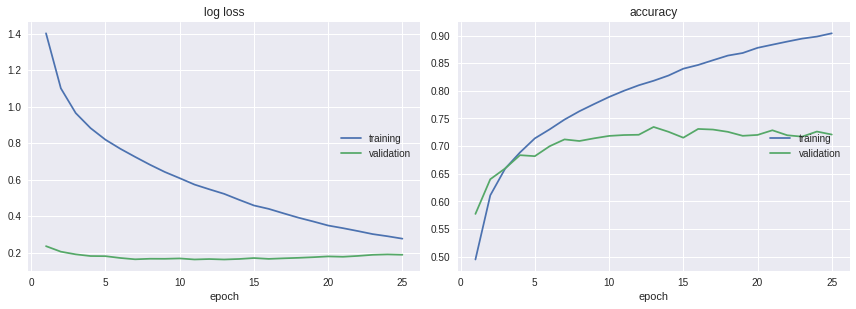

In [227]:
liveloss.draw()

### 72% <-- Highest Accuracy so far